In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from history_data import *

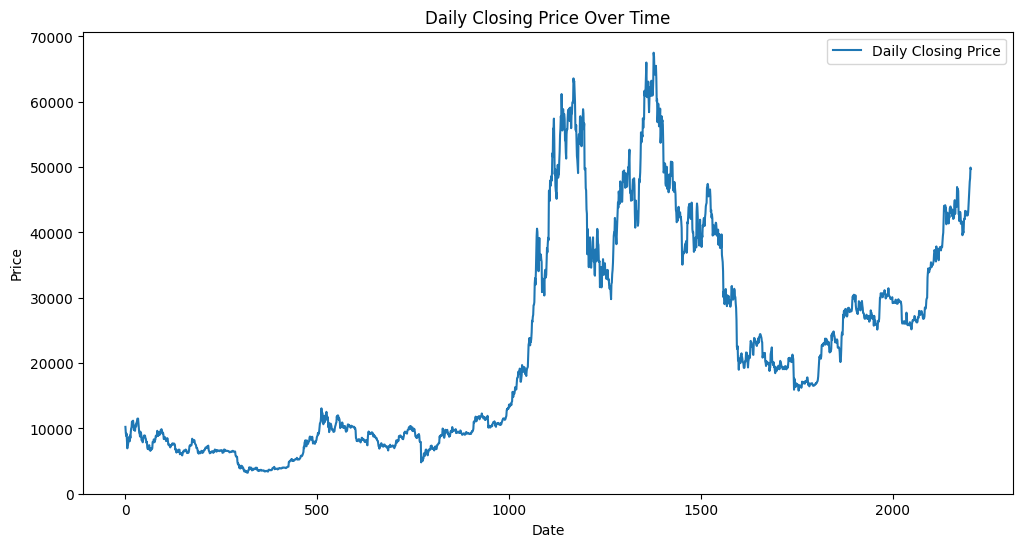

In [23]:
# Load data
symbol = 'BTC'
start_date = '2016-05-01'
# Read 1day data into a Pandas DataFrame
data = get_trade_data(symbol, 
                    start_date, 
                    'OneDay', 
                    calculate_moving_averages = True,
                    local_test=True)

# Visualize the closing price
plt.figure(figsize=(12, 6))
plt.plot(data['close'], label='Daily Closing Price')
plt.title('Daily Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [24]:
data.columns

Index(['BaseCurrency', 'open', 'high', 'low', 'close', 'close_date',
       'close_datetime', 'close_epoch', 'volume', 'ma_8', 'ma_10', 'ma_20',
       'ma_34', 'ma_50', 'ma_100', 'ma_150', 'ma_200', 'ma_300', 'ma_400',
       'ma_500'],
      dtype='object')

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Assume 'close', 'volume', and 'ma_50' need to be included
features = data[['close', 'volume', 'ma_50']]

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Convert scaled data to sequences and corresponding labels
def to_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, 0]  # Assuming 'close' price is at index 0
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Number of time steps in each input sequence
X, y = to_sequences(scaled_features, seq_length)



In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Model definition
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


2024-05-25 16:25:26.806295: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
55/55 [==============================] - 5s 24ms/step - loss: 0.0170 - val_loss: 9.9939e-04
Epoch 2/50
55/55 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 7.3191e-04
Epoch 3/50
55/55 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 8.9671e-04
Epoch 4/50
55/55 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 5/50
55/55 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 8.9333e-04
Epoch 6/50
55/55 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 6.3734e-04
Epoch 7/50
55/55 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 8/50
55/55 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 7.1569e-04
Epoch 9/50
55/55 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 5.3832e-04
Epoch 10/50
55/55 [==============================] - 1s 11ms/step - loss: 0.0019 - val_l

In [9]:
from sklearn.metrics import mean_squared_error

# Making predictions
predicted = model.predict(X_test)

# Calculating MSE for the predictions
mse = mean_squared_error(y_test, predicted)
print(f'MSE: {mse}')


14/14 [==============================] - 1s 4ms/step
MSE: 0.000280405592634776


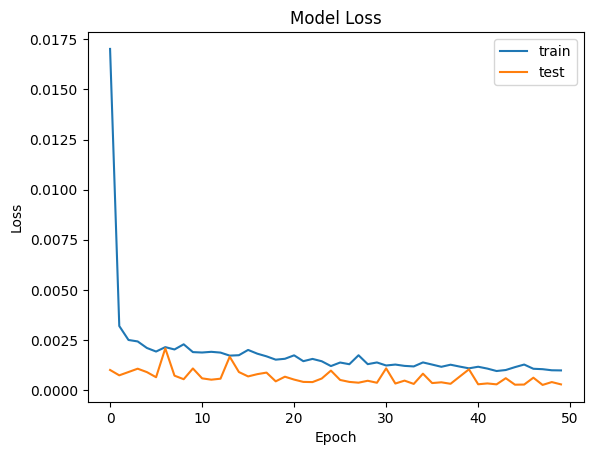

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


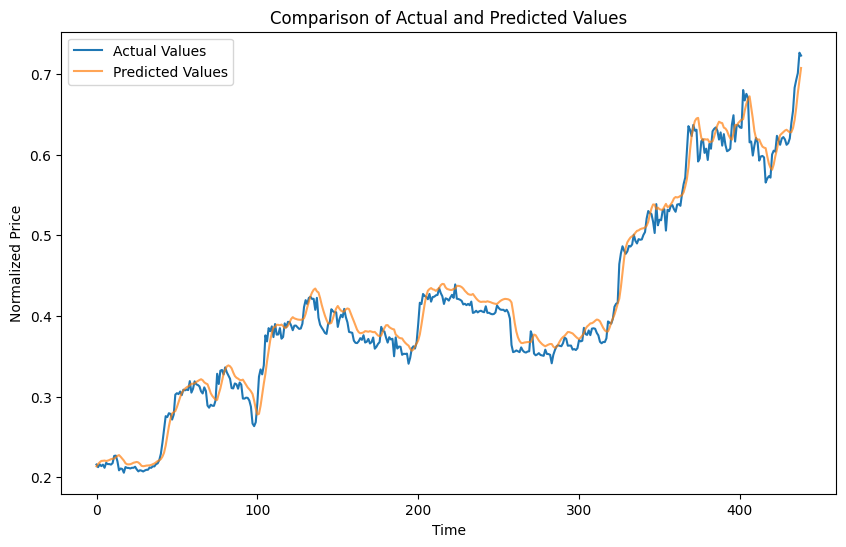

In [11]:
# Assuming you have y_test and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(predicted, label='Predicted Values', alpha=0.7)
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()


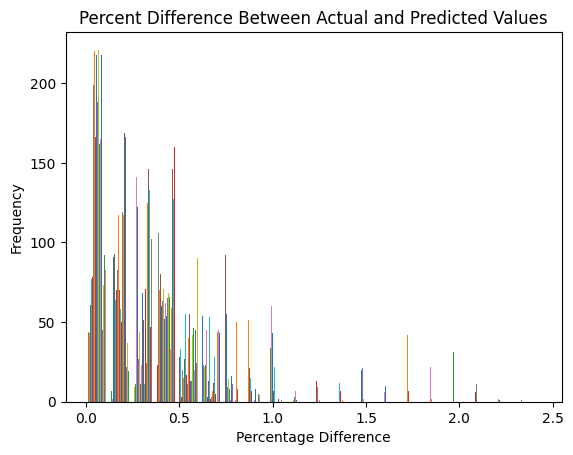

In [21]:
# create a dataframe with the percent difference between the actual and predicted values and then plot histogram. Change all numbers to positive values
percent_diff = np.abs((y_test - predicted) / y_test)
plt.hist(percent_diff, bins=20)
plt.title('Percent Difference Between Actual and Predicted Values')
plt.xlabel('Percentage Difference')
plt.ylabel('Frequency')
plt.show()

In [22]:
# print values where the y_test minus predicted is greater than 0.1
print(y_test[predicted.flatten() - y_test.flatten() > 0.1])
print(predicted[predicted.flatten() - y_test.flatten() > 0.1])


[]
[]
